In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.122:36821")
client

Client Scheduler: tcp://10.32.2.122:36821 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


# For ECCO

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

# Validating Heat Budget (w zarr ds)

In [3]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_th.zarr'))
ds

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 270, 360), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 270, 360, 50), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

### Entire WG column budget

In [4]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [5]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [6]:
ds_wg = ds.isel(**lat_range, **lon_range)
#ds_wg_surf = ds_surf.isel(**lat_range, **lon_range)

In [17]:
rhs_heat = (ds_wg.conv_horiz_diff_flux_TH +
           ds_wg.conv_horiz_adv_flux_TH + 
           ds_wg.sw_flux_conv_TH + 
           ds_wg.surface_flux_conv_TH).sum(dim=['i', 'j', 'k']).load()

lhs_heat = ds_wg.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

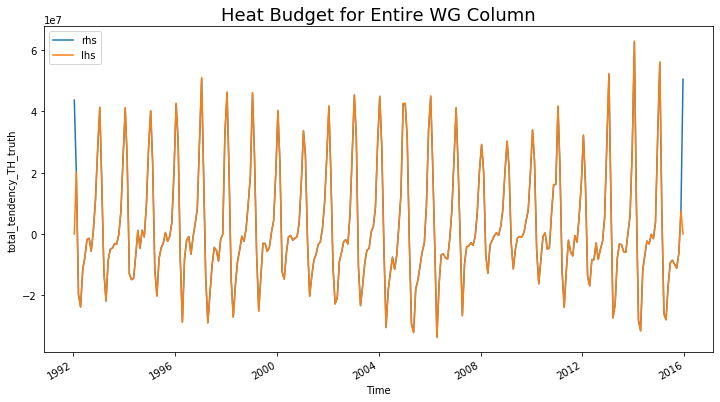

In [19]:
plt.figure(figsize=(12,6))
rhs_heat.plot(label='rhs')
lhs_heat.plot(label='lhs')
plt.legend()
plt.title('Heat Budget for Entire WG Column', fontsize=18);

Going to try adding zeros to surf-flux-term to have full depth of 50 levels since xarray could be broadcasting... - (update: didn't work)

### Interior WG column budget

In [12]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167

lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [13]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [14]:
ds_wg_lower = ds.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_wg_lower

<xarray.Dataset>
Dimensions:                  (i: 92, j: 40, k: 13, time: 288)
Coordinates:
  * k                        (k) int64 36 37 38 39 40 41 42 43 44 45 46 47 48
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(13, 1, 40, 92), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 40, 92, 13), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>

In [15]:
rhs_heat_lower = ((ds_wg_lower.conv_horiz_adv_flux_TH + 
                  ds_wg_lower.conv_horiz_diff_flux_TH + 
                  ds_wg_lower.conv_vert_adv_flux_TH +
                  ds_wg_lower.conv_vert_diff_flux_TH).sum(dim=['i', 'j', 'k'])).load()

lhs_heat_lower = ds_wg_lower.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

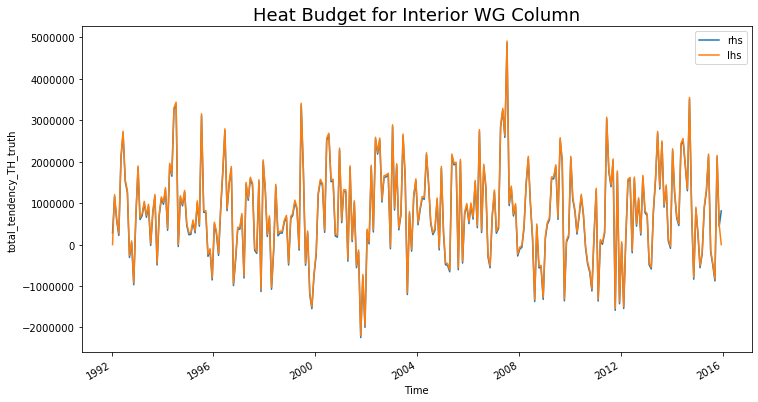

In [16]:
plt.figure(figsize=(12,6))
rhs_heat_lower.plot(label='rhs')
lhs_heat_lower.plot(label='lhs')
plt.legend()
plt.title('Heat Budget for Interior WG Column', fontsize=18);

# Validating Salt Budget (w zarr ds)

In [20]:
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_slt.zarr'))
ds_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288, time_snp: 287)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 270, 360), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

### Entire WG column budget

In [21]:
ds_slt_wg = ds_slt.isel(**lat_range, **lon_range)
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (i: 92, j: 40, k: 50, time: 288, time_snp: 287)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 40, 92), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>

In [38]:
rhs_slt = ((ds_slt_wg.conv_horiz_adv_flux_SLT +
            ds_slt_wg.conv_horiz_diff_flux_SLT +
            ds_slt_wg.salt_plume).sum(dim=['i', 'j', 'k']) +
            ds_slt_wg.surface_flux_SLT.sum(dim=['i', 'j'])).load()

lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

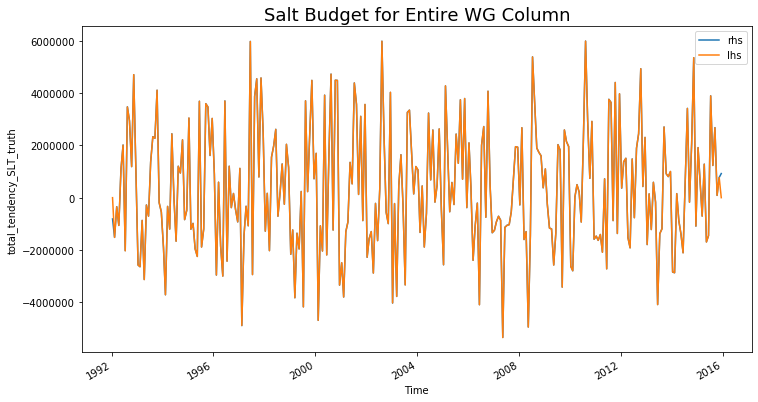

In [39]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend()
plt.title('Salt Budget for Entire WG Column', fontsize=18);

### Interior WG column budget

In [40]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167

lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [41]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [42]:
ds_slt_wg_lower = ds_slt.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_slt_wg_lower

<xarray.Dataset>
Dimensions:                   (i: 92, j: 40, k: 13, time: 288, time_snp: 287)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    surface_flux_SLT          (time, j, i) float32 dask.array<chunksize=(1, 40, 92), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>

In [43]:
rhs_slt_lower = (ds_slt_wg_lower.conv_horiz_adv_flux_SLT +
                 ds_slt_wg_lower.conv_horiz_diff_flux_SLT +
                 ds_slt_wg_lower.conv_vert_adv_flux_SLT +
                 ds_slt_wg_lower.conv_vert_diff_flux_SLT + 
                 ds_slt_wg_lower.salt_plume).sum(dim=['i', 'j', 'k']).load()

lhs_slt_lower = ds_slt_wg_lower.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

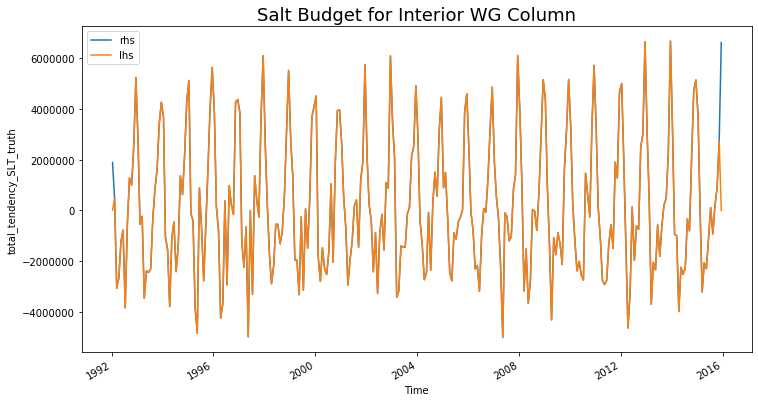

In [44]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend()
plt.title('Salt Budget for Interior WG Column', fontsize=18);